In [147]:
import tensorflow as tf
import tensorflow_addons as tfa

import math
import seaborn as sns
import numpy as np

from scipy.special import softmax
from itertools import permutations, combinations, combinations_with_replacement
from scipy.stats import multivariate_normal, truncnorm, norm, multinomial
from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy

In [148]:
n_i = 3
n_pair_query = int(math.factorial(n_i) / (math.factorial(n_i - 2) * 2))
n_config = 5
n = 33
n_category = n // n_i
mu = [(0, 0), (5, 0), (4, 3)]
var = 0.01
it = 5000
rand_weight = 0.1

In [149]:
def generate_points(n, mu_s, var, visual=True, shuffle=True, seed=0):
    np.random.seed(seed)
    n_category = len(mu_s)

    covar = [
        np.diag([var for _ in range(2)])
        for _ in range(n_category)
    ]

    gmm = [
        multivariate_normal(mean=mu_s[i], cov=covar[i])
        for i in range(n_category)
    ]

    points = []
    labels = []

    for _i, dist in enumerate(gmm):
        points += list(dist.rvs(size=n // n_category))
        labels += [_i for _ in range(n // n_category)]

    points = np.array(points)
    labels = np.array(labels)

    if shuffle:
        rand_idx = np.array(list(range(n)))
        np.random.shuffle(rand_idx)
        points = points[rand_idx]
        labels = labels[rand_idx]
    

    if visual:
        sns.scatterplot(x=points[:, 0], y=points[:, 1], hue=labels)

    return points, labels

In [150]:
def generate_queries_and_true_configs(points, labels, n_i, n_pair_query, rand_weight, seed=0):
    np.random.seed(seed)
    idx = range(len(points))
    queries = list(permutations(idx, r=n_i))

    configs_expanded = [] 
    configs = []
    distances = []
    distances_noise = []

    for query in queries:
        config_expanded = labels[list(query)]
        config = []
        r = []
        r_noise = []
        for left, right in combinations(range(n_pair_query), 2):
            config.append(int(config_expanded[left] == config_expanded[right]))
            r.append(np.linalg.norm(points[query[left]] - points[query[right]]))
        r_noise = truncnorm.rvs(min(r), np.inf, size=len(r)).astype(np.float32) * rand_weight + np.array(r, dtype=np.float32)

        configs_expanded.append(config_expanded)
        configs.append(config)
        distances.append(r)
        distances_noise.append(r_noise)

    possible_configs = dict(zip(sorted(set(map(tuple, configs))), range(5)))

    one_hot_configs = []
    for config in configs:
        config_id = possible_configs[tuple(config)]
        one_hot_config = np.zeros(len(possible_configs))
        one_hot_config[config_id] = 1
        one_hot_configs.append(one_hot_config)
    
    return np.array(queries),np.array(one_hot_configs), np.array(configs_expanded), np.array(distances), np.array(distances_noise)

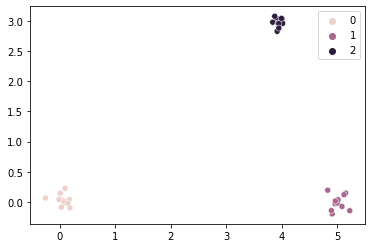

In [151]:
points, labels = generate_points(n, mu, var)
points = points.astype(np.float32)
labels = labels.astype(np.float32)

In [152]:
queries, configs, configs_expanded, r, r_noise = generate_queries_and_true_configs(points, labels, n_i, n_pair_query, rand_weight=rand_weight)

In [153]:
bias = 1.5
W = np.array([[ 1,  1,  1],
              [ 1,  1, -1],
              [ 1, -1,  1],
              [-1,  1,  1],
              [-1, -1, -1]], dtype=np.float32)
b = (-bias * W).sum(axis=1).reshape(-1, 1)

In [154]:
W = W.T
b = b.T

In [155]:
np.random.seed(0)
W_noise = W + norm.rvs(size=W.shape).astype(np.float32) * rand_weight
b_noise = b + norm.rvs(size=b.shape).astype(np.float32) * rand_weight

In [156]:
r_noise

array([[4.977847  , 0.20537764, 4.8933506 ],
       [5.2429514 , 3.5836022 , 5.270163  ],
       [4.959963  , 0.24166518, 5.081025  ],
       ...,
       [0.2210871 , 0.49615136, 0.25321734],
       [0.3485406 , 3.6420965 , 3.250755  ],
       [0.40217048, 0.4533726 , 0.21140775]], dtype=float32)

In [157]:
W_noise

array([[ 1.1764052 ,  1.0400157 ,  1.0978738 , -0.7759107 , -0.8132442 ],
       [ 0.9022722 ,  1.0950089 , -1.0151358 ,  0.98967814, -0.95894015],
       [ 1.0144043 , -0.85457265,  1.0761038 ,  1.0121675 , -0.9556137 ]],
      dtype=float32)

In [158]:
b_noise

array([[-4.4666324, -1.3505921, -1.5205158, -1.4686933,  4.4145904]],
      dtype=float32)

# Optimize for $W, b, \text{and } r$

In [159]:
@tf.function
def f(W, r, b, Y):
    Y_hat = tf.nn.softmax(tf.matmul(r, W) + b)
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(Y, Y_hat)
    return loss

In [160]:
def accuracy(W_hat, r_hat, b_hat, Y):
    W_hat = W_hat.numpy() if type(W_hat) is tf.Tensor else W_hat
    r_hat = r_hat.numpy() if type(r_hat) is tf.Tensor else r_hat
    b_hat = b_hat.numpy() if type(b_hat) is tf.Tensor else b_hat
    Y = Y.numpy() if type(Y) is tf.Tensor else Y

    res = r_hat @ W_hat + b_hat
    idx_hat = np.argmax(res, axis=1)
    idx = np.argmax(Y, axis=1)
    
    print("Accuracy:", np.sum(idx_hat == idx) / Y.shape[0])

In [161]:
def generate_label_from_pmf(W, r, b, seed=0):
    np.random.seed(seed)

    logits = r @ W + b
    probs = softmax(logits, axis=1)

    Y_drawn = []

    for prob in probs:
        prob = prob.astype(np.float64)
        prob = prob / prob.sum()
        drawn = multinomial.rvs(1, p=prob)
        Y_drawn.append(drawn)
    
    return np.array(Y_drawn).astype(np.float32)

In [162]:
def optimize_together(opt, it, func, W, r, b, Y):
    for _ in range(it):
        with tf.GradientTape() as tape:
            loss = func(W, r, b, Y)

        grads = tape.gradient(loss, [W, r, b])
        opt.apply_gradients(zip(grads, [W, r, b]))
    
    print(f"Final loss {it} ", func(W, r, b, Y).numpy())
    return W, r, b

In [163]:
def optimize_seperately(opt1, opt2, it, it1, it2, func, W, r, b, Y):
    for _ in range(it):

        for _ in range(it1):
            with tf.GradientTape() as tape:
                loss = func(W, r, b, Y)
            grads = tape.gradient(loss, [W, b])
            opt1.apply_gradients(zip(grads, [W, b]))

        for _ in range(it2):
            with tf.GradientTape() as tape:
                loss = func(W, r, b, Y)
            grads = tape.gradient(loss, [r])
            opt2.apply_gradients(zip(grads, [r]))
        
    print(f"Final loss {it} ", func(W, r, b, Y).numpy())
    return W, r, b

In [164]:
def show_diff(W_hat, r_hat, r, b_hat, Y, wrong_only=False):
    W_hat = W_hat.numpy() if type(W_hat) is tf.Tensor else W_hat
    r_hat = r_hat.numpy() if type(r_hat) is tf.Tensor else r_hat
    b_hat = b_hat.numpy() if type(b_hat) is tf.Tensor else b_hat
    Y = Y.numpy() if type(Y) is tf.Tensor else Y

    res = r_hat @ W_hat + b_hat
    idx_hat = np.argmax(res, axis=1)
    idx = np.argmax(Y, axis=1)

    for i in range(len(idx)):
        if wrong_only:
            if idx_hat[i] == idx[i]:
                continue
        print(f"r_hat: {r_hat[i]}, r: {r[i]}, y_hat: {idx_hat[i]}, y: {idx[i]}")

In [165]:
def show_mean_distances(mu):
    for left, right in combinations(mu, 2):
        print(np.linalg.norm(np.array(left) - np.array(right)))

In [166]:
r_noise = tf.Variable(r_noise, tf.float32)
Y = tf.Variable(configs.astype(np.float32), tf.float32)
W_noise = tf.Variable(W_noise, tf.float32)
b_noise = tf.Variable(b_noise, tf.float32)
Y_drawn = generate_label_from_pmf(W, r, b)

In [167]:
W_hat, r_hat, b_hat = optimize_seperately(tfa.optimizers.SGDW(learning_rate=0.01, momentum=0.8, weight_decay=0), 
                                          tfa.optimizers.SGDW(learning_rate=0.01, momentum=0, weight_decay=0),
                                          400, 
                                          10,
                                          3,
                                          f, W_noise, r_noise, b_noise, Y_drawn)

2022-07-21 19:32:26.399562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 19:32:26.487350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Final loss 400  0.22477643


2022-07-21 19:32:56.833742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [168]:
W

array([[ 1.,  1.,  1., -1., -1.],
       [ 1.,  1., -1.,  1., -1.],
       [ 1., -1.,  1.,  1., -1.]], dtype=float32)

In [169]:
b

array([[-4.5, -1.5, -1.5, -1.5,  4.5]], dtype=float32)

In [170]:
r

array([[4.8967786 , 0.09357975, 4.8032565 ],
       [4.8967786 , 3.2438378 , 4.9172926 ],
       [4.8967786 , 0.07790579, 4.869114  ],
       ...,
       [0.17250594, 0.38745013, 0.22936837],
       [0.17250594, 3.3090045 , 3.1782079 ],
       [0.17250594, 0.34742042, 0.1893384 ]], dtype=float32)

In [171]:
W_hat.numpy()

array([[ 1.0896639 ,  1.1381477 ,  1.1030256 , -0.7893699 , -0.8162965 ],
       [ 0.97084445,  0.9512065 , -0.9089267 ,  0.9920236 , -0.9922741 ],
       [ 1.0082045 , -0.8277773 ,  1.0394324 ,  1.029681  , -0.95704794]],
      dtype=float32)

In [172]:
b_hat.numpy()

array([[-4.4687257, -1.4541985, -1.5367512, -1.4765407,  4.5443134]],
      dtype=float32)

In [173]:
r_hat.numpy()

array([[4.977847  , 0.20534179, 4.8933506 ],
       [5.2429514 , 3.5836022 , 5.270163  ],
       [4.959963  , 0.24162929, 5.081025  ],
       ...,
       [0.22106922, 0.4961484 , 0.25321734],
       [0.34846908, 3.6420965 , 3.250755  ],
       [0.40217048, 0.45335686, 0.21138987]], dtype=float32)

In [174]:
accuracy(W, r, b, Y_drawn)

Accuracy: 0.9428763440860215


In [175]:
accuracy(W_hat, r_hat, b_hat, Y_drawn)

Accuracy: 0.9428763440860215
